In [3]:
# Imports & Setup
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

%matplotlib inline
np.random.seed(123) #Random seed for reproducibility

In [ ]:
# Directory & Image Merging
base_skin_dir = os.path.join('.', 'data')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {'nv': 'Melanocytic nevi', 'mel': 'Melanoma', 'bkl': 'Benign keratosis-like lesions ',
                    'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses', 'vasc': 'Vascular lesions',
                    'df': 'Dermatofibroma'}

In [ ]:
# Read metadata
metadata_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
metadata_df['path'] = metadata_df['image_id'].map(imageid_path_dict.get)
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get) 
metadata_df['cell_type_idx'] = pd.Categorical(metadata_df['cell_type']).codes

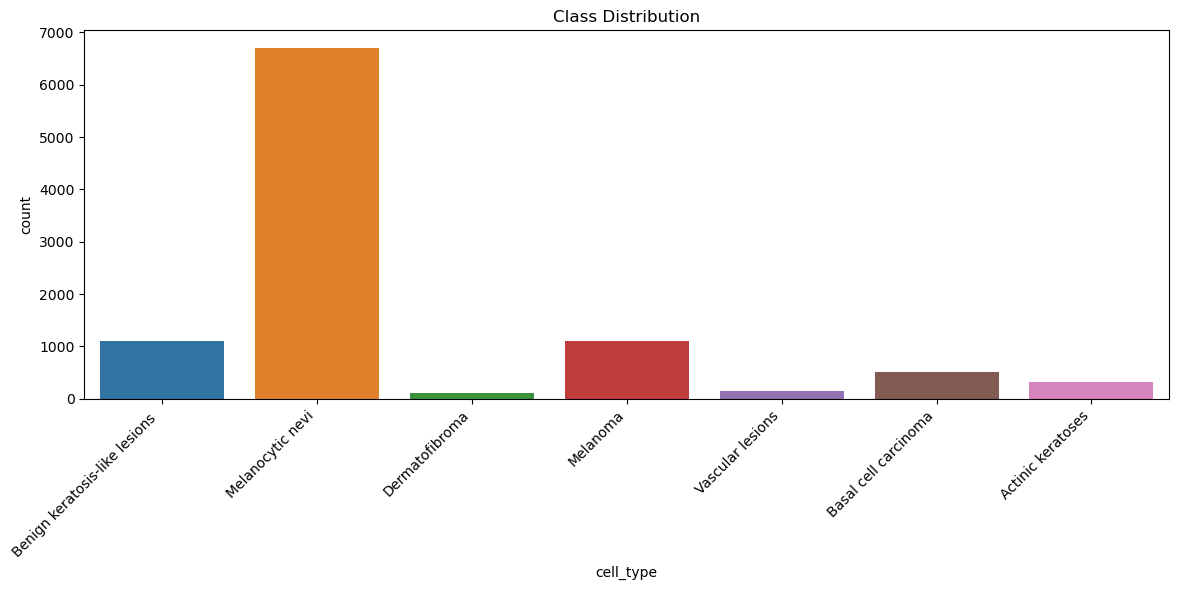

In [ ]:
# Check class distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='cell_type', data=metadata_df)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [ ]:
metadata_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
# Handle missing values
metadata_df['age'].fillna((metadata_df['age'].mean()), inplace=True)
metadata_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

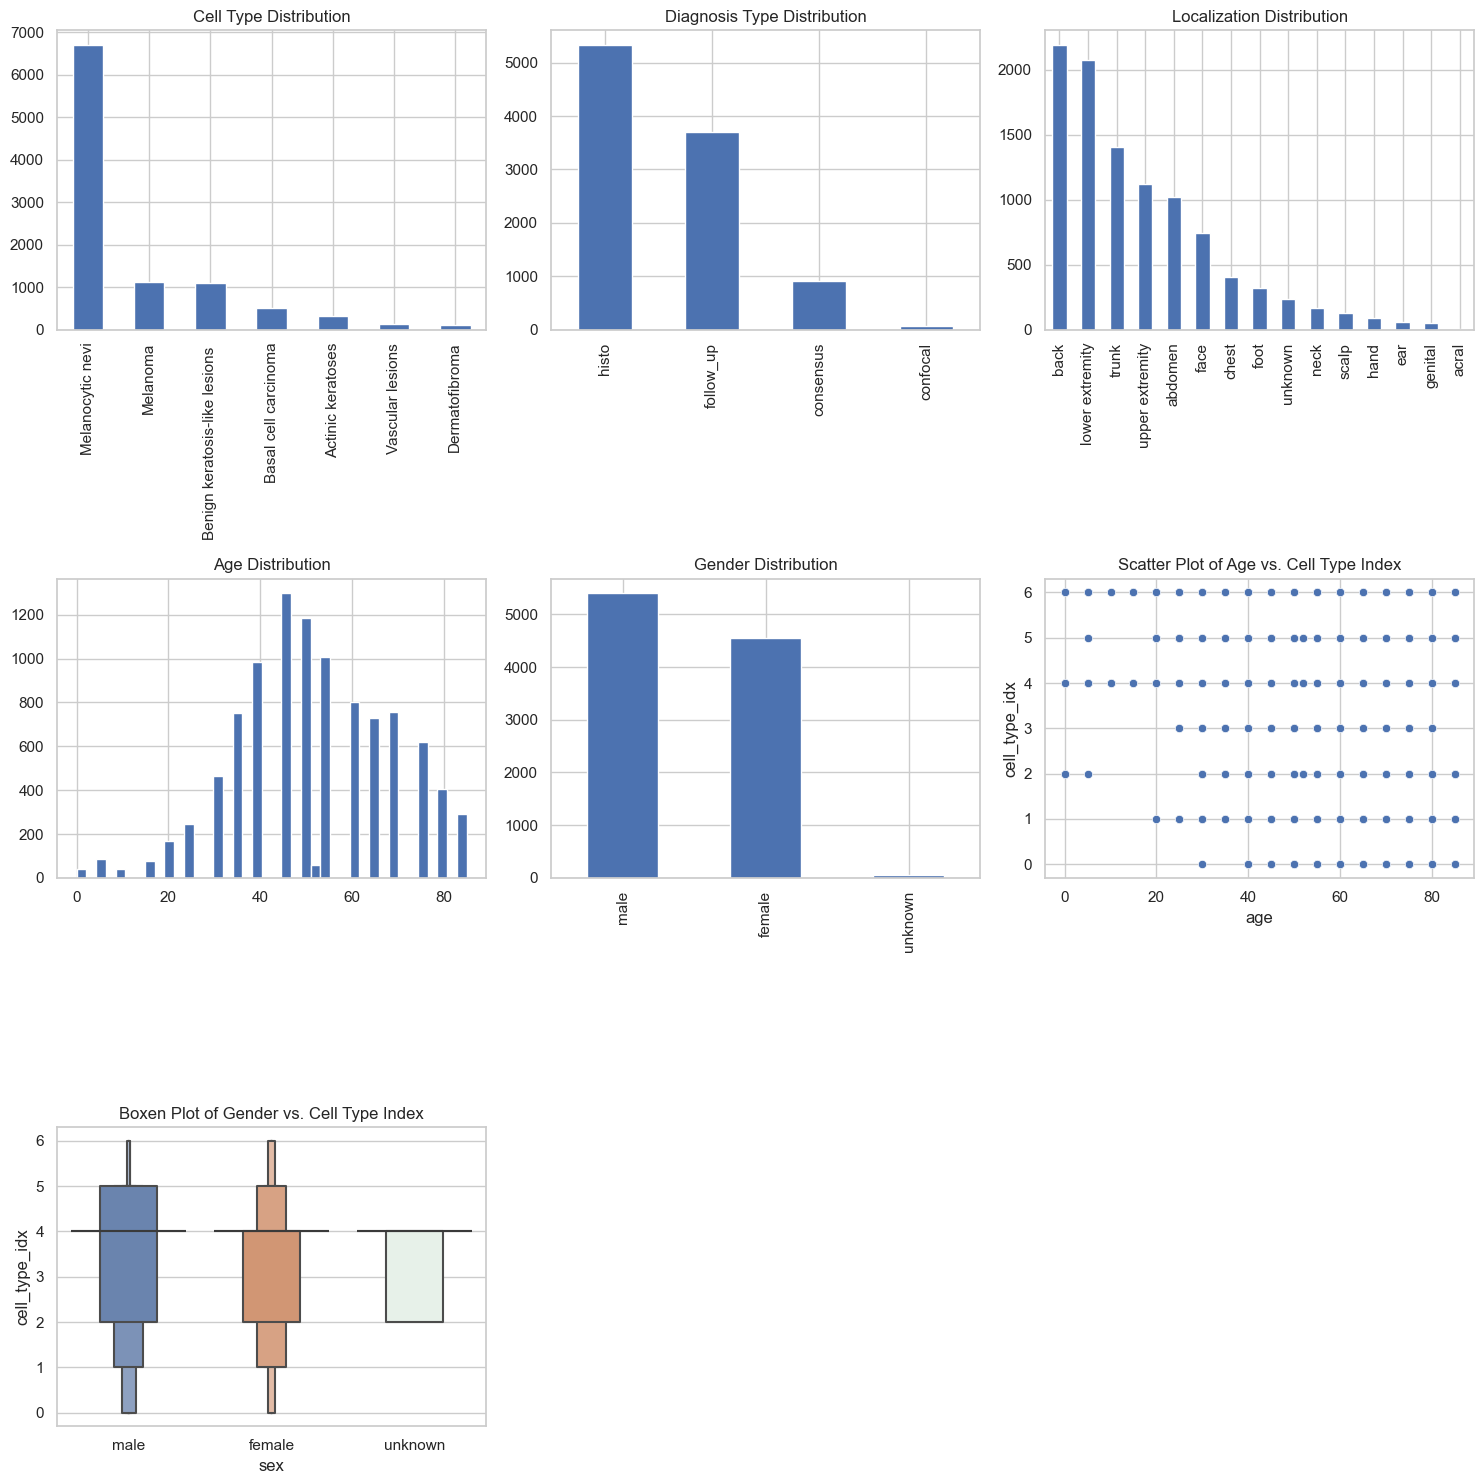

In [ ]:
# Data Exploration
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

metadata_df['cell_type'].value_counts().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Cell Type Distribution')

metadata_df['dx_type'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Diagnosis Type Distribution')

metadata_df['localization'].value_counts().plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Localization Distribution')

metadata_df['age'].hist(bins=40, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution')

metadata_df['sex'].value_counts().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution')

sns.scatterplot(x='age', y='cell_type_idx', data=metadata_df, ax=axes[1, 2])
axes[1, 2].set_title('Scatter Plot of Age vs. Cell Type Index')

# Use boxenplot directly
sns.boxenplot(x='sex', y='cell_type_idx', data=metadata_df, ax=axes[2, 0])
axes[2, 0].set_title('Boxen Plot of Gender vs. Cell Type Index')

# Hide the empty subplot in the last row and column
axes[2, 1].axis('off')
axes[2, 2].axis('off')

# Adjust layout with reasonable space between rows
plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.show()

In [ ]:
metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


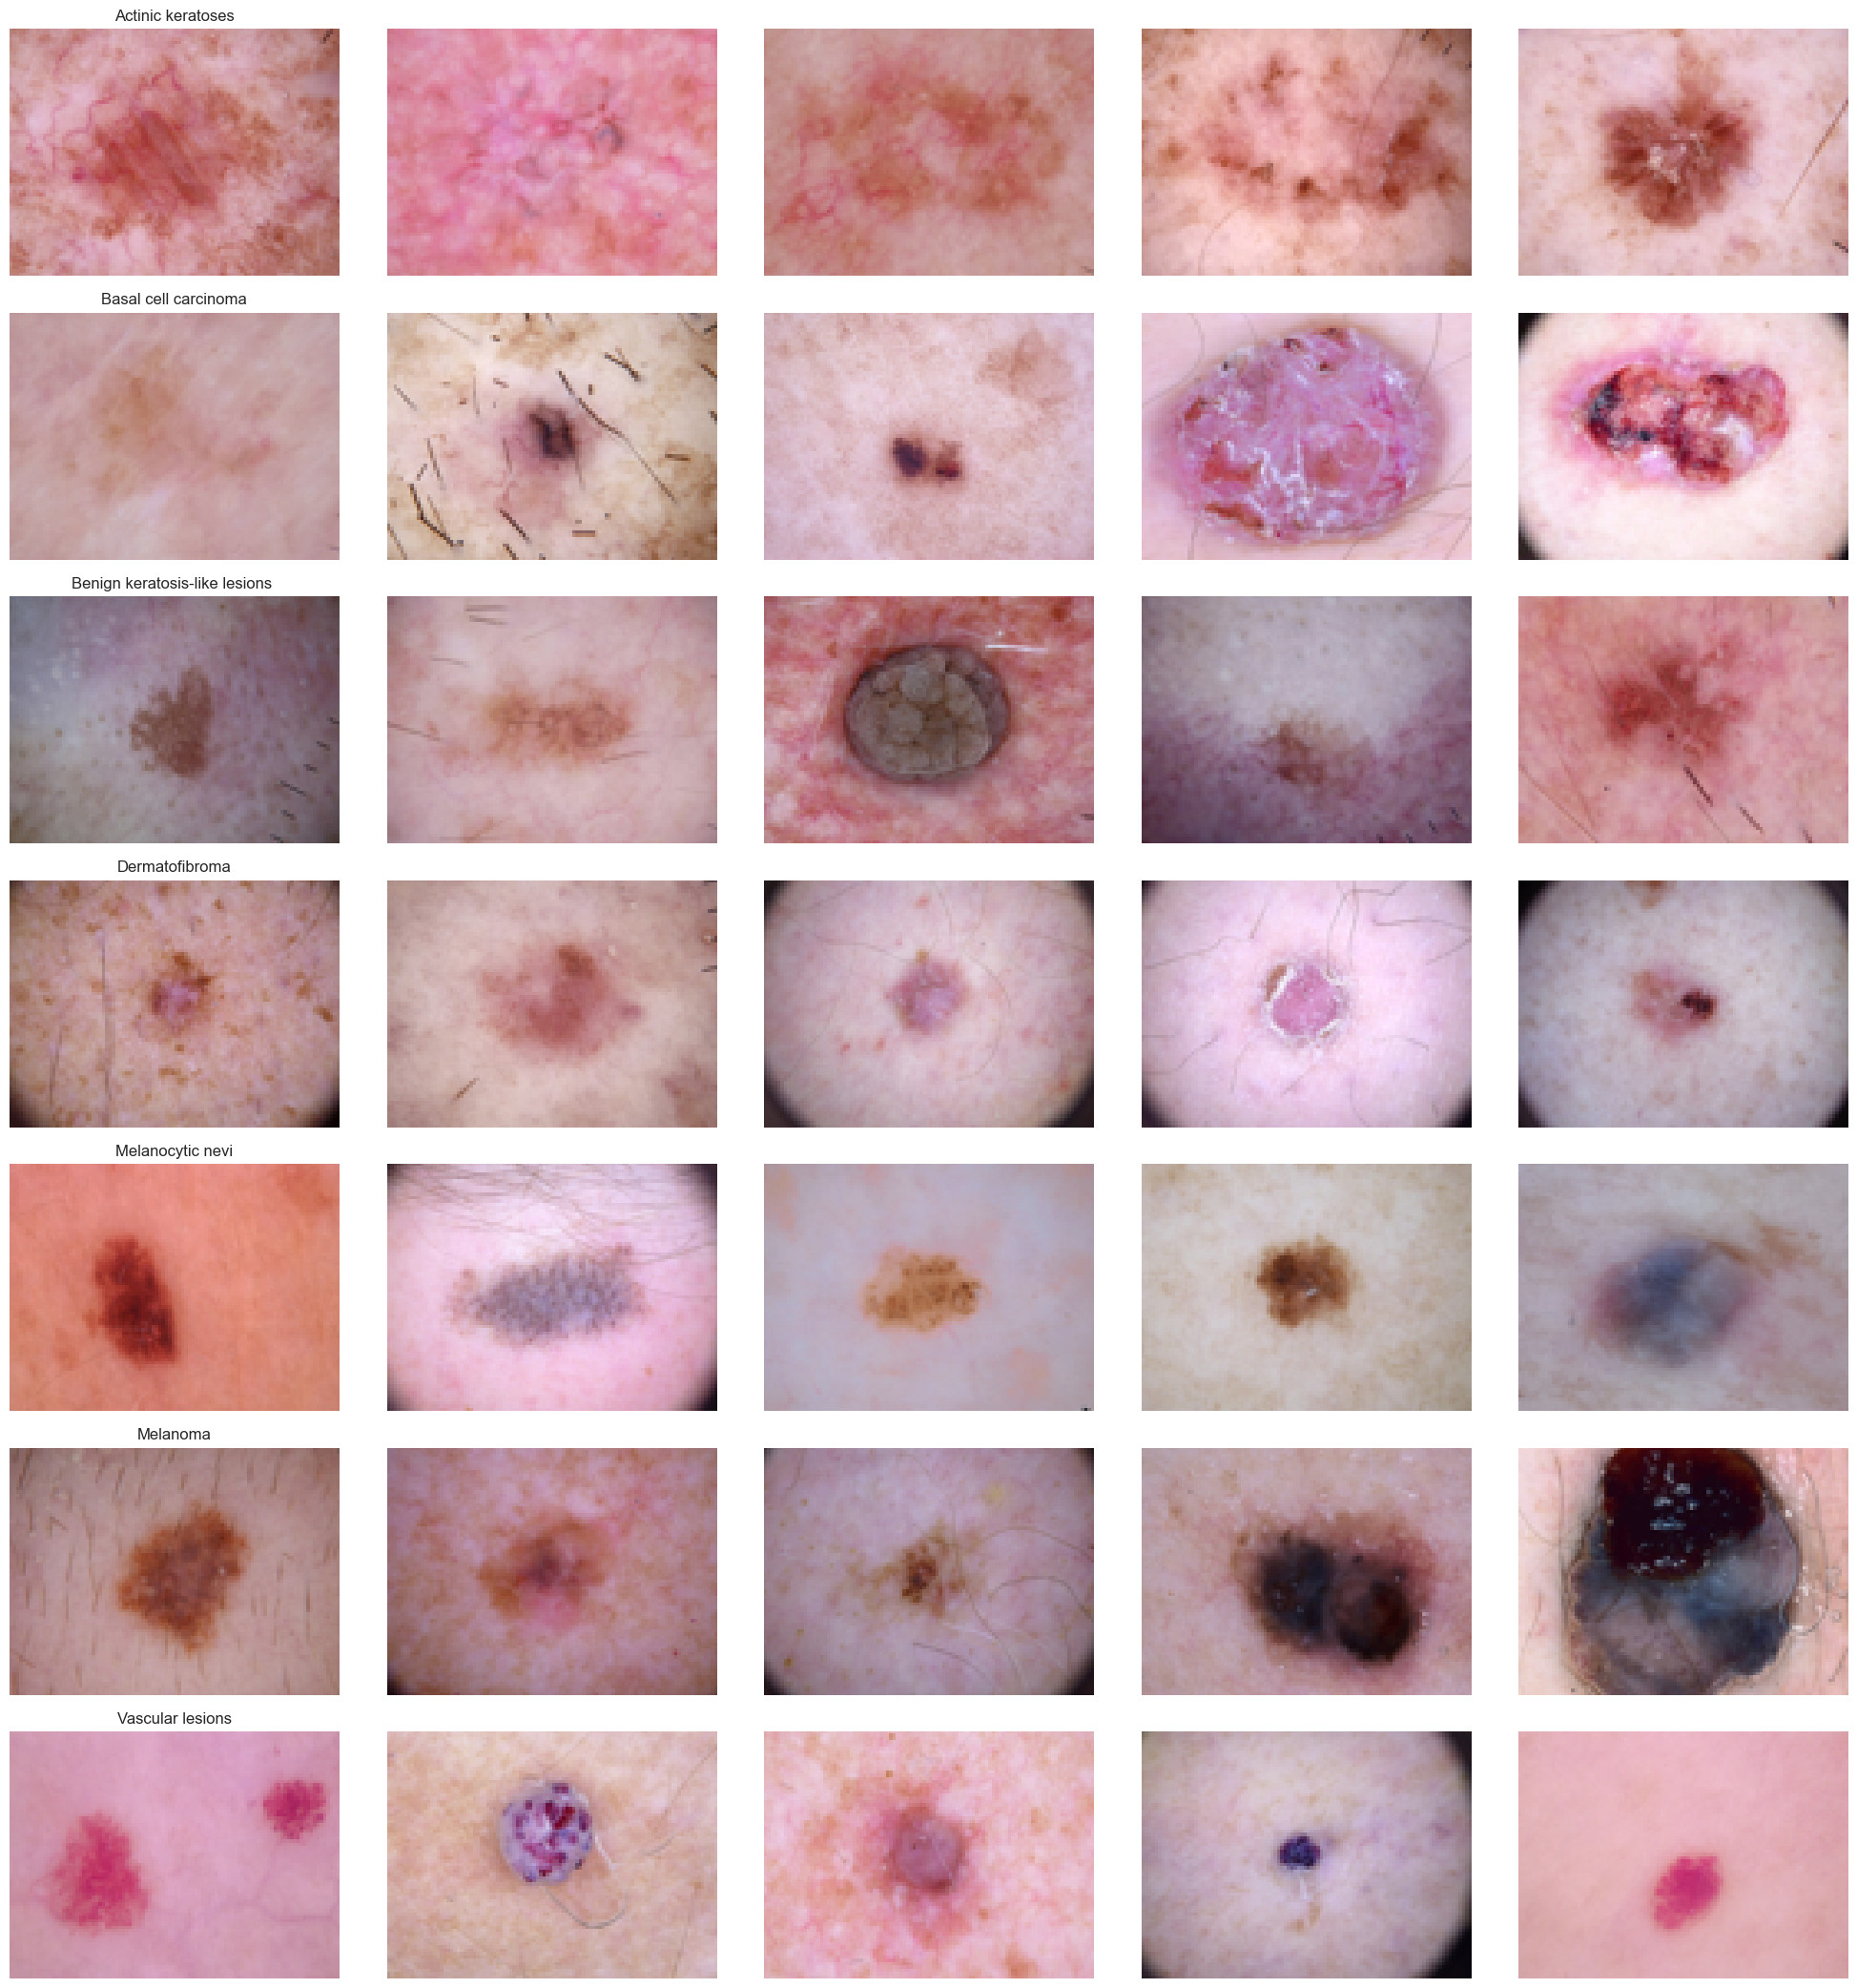

In [ ]:
# Display 5 samples for each cell type
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs, metadata_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        if 'image' in c_row.index:
            c_ax.imshow(c_row['image'])
            c_ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Checking the image size distribution
metadata_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [ ]:
# Prepare data for modeling
features = metadata_df.drop(columns=['cell_type_idx'], axis=1)
target = metadata_df['cell_type_idx']
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1234)

In [ ]:
# Extract image arrays
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# Standardize image data
x_train_mean, x_train_std = np.mean(x_train), np.std(x_train)
x_test_mean, x_test_std = np.mean(x_test), np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

In [ ]:
# Split training set into training and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train_o, test_size=0.1, random_state=2)

In [ ]:
# Reshape image dimensions
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
# Set up the CNN model
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='Same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-01-12 02:12:22.245914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 02:12:22.246096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 64)       1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 64)       36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 128)       147584    
                                                        

In [ ]:
# Define the optimizer
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(x_train)

In [ ]:
# Fit the model
epochs = 60
batch_size = 10 
history = model.fit_generator(datagen.flow( x_train, y_train,batch_size=batch_size),
                                          epochs=epochs, 
                                          validation_data=(x_validate, y_validate),
                                          verbose=1, 
                                          steps_per_epoch=x_train.shape[0] // batch_size
                                          )


Epoch 1/60


/var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/ipykernel_10951/1788301786.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow( x_train, y_train,
2024-01-12 02:12:55.214410: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-12 02:12:55.492905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


720/721 [============================>.] - ETA: 0s - loss: 1.0037 - accuracy: 0.6646

2024-01-12 02:13:18.409874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


721/721 [==============================] - 24s 32ms/step - loss: 1.0041 - accuracy: 0.6644 - val_loss: 0.8767 - val_accuracy: 0.6808
Epoch 2/60
721/721 [==============================] - 24s 33ms/step - loss: 0.8952 - accuracy: 0.6707 - val_loss: 0.8198 - val_accuracy: 0.6895
Epoch 3/60
721/721 [==============================] - 23s 32ms/step - loss: 0.8421 - accuracy: 0.6893 - val_loss: 0.7911 - val_accuracy: 0.7195
Epoch 4/60
721/721 [==============================] - 23s 32ms/step - loss: 0.8006 - accuracy: 0.6996 - val_loss: 0.7401 - val_accuracy: 0.7195
Epoch 5/60
721/721 [==============================] - 23s 32ms/step - loss: 0.7787 - accuracy: 0.7119 - val_loss: 0.6967 - val_accuracy: 0.7406
Epoch 6/60
721/721 [==============================] - 23s 32ms/step - loss: 0.7495 - accuracy: 0.7251 - val_loss: 0.7262 - val_accuracy: 0.7232
Epoch 7/60
721/721 [==============================] - 23s 32ms/step - loss: 0.7330 - accuracy: 0.7287 - val_loss: 0.6981 - val_accuracy: 0.7431
Epo

In [ ]:
# Evaluate model on test set
loss, accuracy = model.evaluate(x_test, y_test_o, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print(f"Validation: accuracy = {accuracy_v:.4f} ; loss_v = {loss_v:.4f}")
print(f"Test: accuracy = {accuracy:.4f} ; loss = {loss:.4f}")

26/26 [==============================] - 1s 22ms/step - loss: 0.6023 - accuracy: 0.7880
Validation: accuracy = 0.7880 ; loss_v = 0.6023
Test: accuracy = 0.7818 ; loss = 0.5916


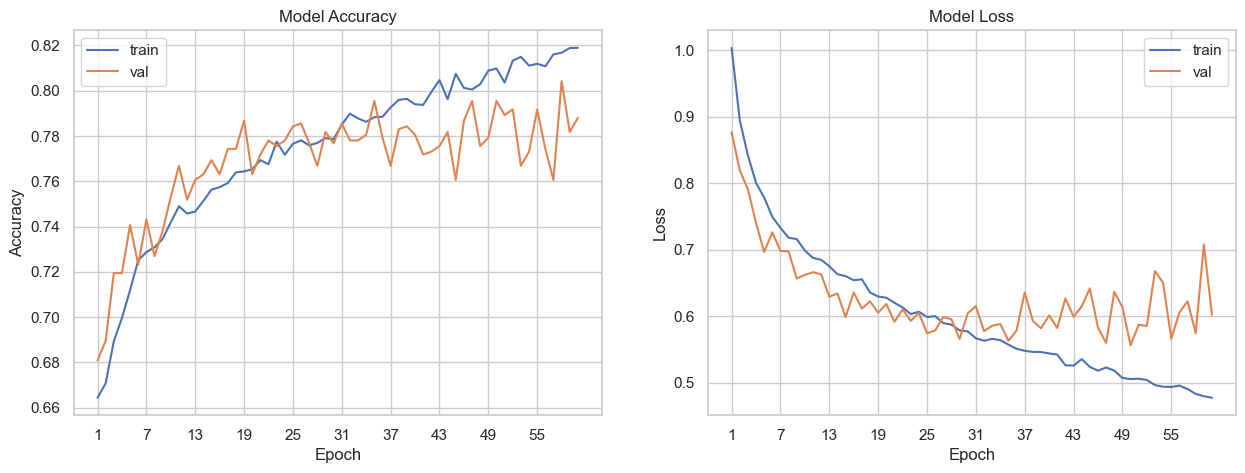

In [ ]:
# Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    if 'accuracy' in model_history.history:
        axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
        axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
        axs[0].set_title('Model Accuracy')
    elif 'acc' in model_history.history:  # For compatibility with older Keras versions
        axs[0].plot(range(1, len(model_history.history['acc']) + 1), model_history.history['acc'])
        axs[0].plot(range(1, len(model_history.history['val_acc']) + 1), model_history.history['val_acc'])
        axs[0].set_title('Model Accuracy')

    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, len(model_history.history['accuracy']) // 10))
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plot loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, len(model_history.history['loss']) // 10))
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

# Plot model training history
plot_model_history(history)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

26/26 [==============================] - 1s 25ms/step


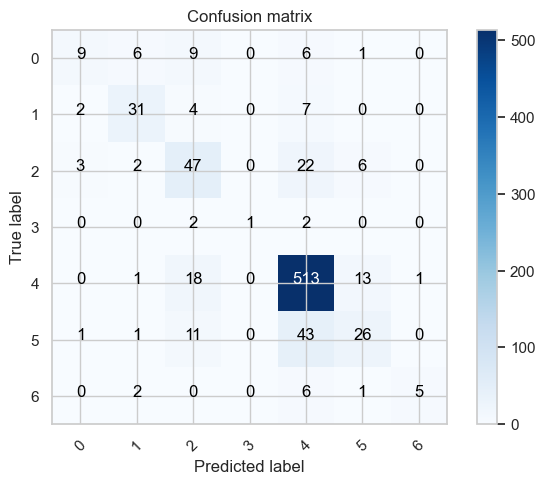

In [ ]:
# Plot confusion matrix
Y_pred = model.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_validate, Y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(7))

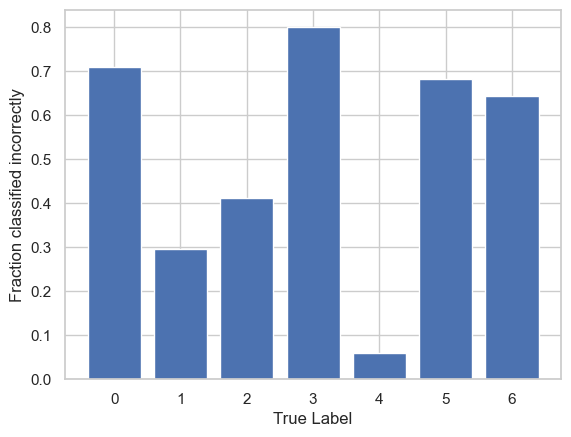

In [ ]:
# Plot fraction of incorrectly classified samples for each label
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7), label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

In [ ]:
# Save the model
model.save("models/skinmodel.h5")

In [1]:
# Load the trained skin cancer classification model
model = tf.keras.models.load_model('models/skinmodel.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('models/skinmodel.tflite', 'wb') as f:
    f.write(tflite_model)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-01-13 21:03:45.736521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 21:03:45.736964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Assets written to: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmp8bgyuyca/assets


INFO:tensorflow:Assets written to: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmp8bgyuyca/assets
2024-01-13 21:03:50.083467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-01-13 21:03:50.083481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-01-13 21:03:50.084921: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmp8bgyuyca
2024-01-13 21:03:50.086916: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-01-13 21:03:50.086924: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmp8bgyuyca
2024-01-13 21:03:50.091997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-01-13 21:03:50.095759: I tensorflow/cc/saved_model/load

### References

[Original Kernel](https://www.kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy)